In [1]:
import os
os.environ["CUDA_VSIBLE_DEVICES"] = '0'
import torch

In [3]:
s = torch.load('./checkpoints/vae/best.pth')
print(s['score'])

0.0005861437570158981


In [4]:
def build_vae(vae_latent_channels=4):
    vae = AutoencoderKL(
        sample_size=128,
        in_channels=3,
        out_channels=3,
        down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"),
        up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"),
        block_out_channels=(64, 128, 256),
        latent_channels=vae_latent_channels,
    )
    return vae


def try_encode_latent(vae, imgs):
    enc = vae.encode(imgs)
    if hasattr(enc, 'latent_dist'):
        try:
            lat = enc.latent_dist.sample()
        except Exception:
            lat = enc.latent_dist.mean
    elif isinstance(enc, dict):
        if 'latent_dist' in enc:
            try:
                lat = enc['latent_dist'].sample()
            except Exception:
                lat = enc['latent_dist'].mean
        elif 'sample' in enc:
            lat = enc['sample']
        else:
            lat = torch.as_tensor(enc)
    else:
        lat = enc
    return lat


def try_decode(vae, latents):
    out = vae.decode(latents)
    if isinstance(out, dict):
        if 'sample' in out:
            return out['sample']
        for v in out.values():
            if isinstance(v, torch.Tensor):
                return v
        raise RuntimeError("Unexpected vae.decode() return structure.")
    elif isinstance(out, torch.Tensor):
        return out
    else:
        return torch.as_tensor(out)


In [5]:
from diffusers import AutoencoderKL
vae = AutoencoderKL(
    sample_size=128,
    in_channels=3,
    out_channels=3,
    down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"),
    up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"),
    block_out_channels=(64, 128, 256),
    latent_channels=4,
).cuda()
vae.load_state_dict(s['model_state_dict'])

/home/zhangran/miniconda3/envs/fusionrl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [ ]:
print(vae.config.scaling_factor)

0.18215


: 

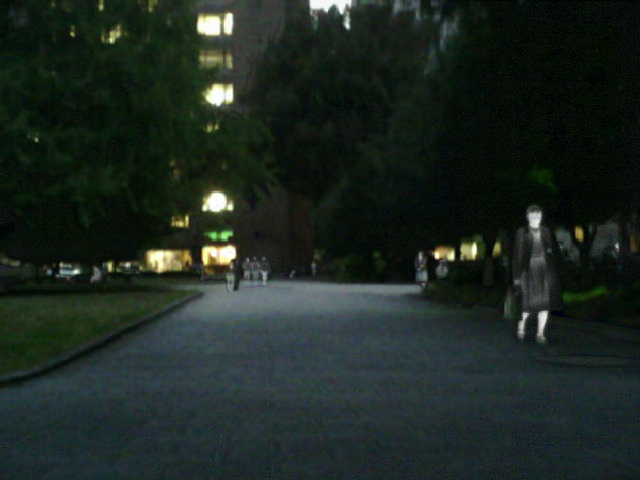

In [6]:
# load images
from PIL import Image
path = ['./data/gen_msrs/00004N.png']
vis = [Image.open(p).convert("RGB") for p in path]
vis[0]

In [9]:
# to tensor [-1,1]
from torchvision.transforms import ToTensor, Normalize, Compose
transform = Compose([ToTensor(), Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
vis = [transform(image).unsqueeze(0).cuda() for image in vis]
vis = torch.cat(vis)
enc = vae.encode(vis)

In [14]:
enc.latent_dist.sample()

tensor([[[[ -8.9824, -11.6607, -13.7108,  ..., -15.3692, -16.6566, -11.4271],
          [ -8.4115, -11.1840, -12.4404,  ..., -14.1911, -13.7938, -13.9281],
          [-10.4383, -11.5991, -10.7371,  ..., -12.8322, -12.6320, -13.7844],
          ...,
          [ -2.8962,  -2.7669,  -4.6890,  ...,  -8.6081,  -7.3252,  -7.9489],
          [ -3.5873,  -3.2294,  -4.9816,  ...,  -5.0779,  -6.3745,  -8.0915],
          [ -4.3719,  -4.5403,  -4.6111,  ...,  -7.8040,  -8.1058,  -7.7295]],

         [[ 10.7027,  18.4699,  17.0262,  ...,  18.3543,  13.7390,  13.9429],
          [ 15.5537,  20.1508,  19.2645,  ...,  21.7978,  14.3896,  14.7759],
          [ 13.4839,  20.7128,  19.2639,  ...,  19.9166,  13.1425,  14.6484],
          ...,
          [ 12.3221,  15.2756,  15.2474,  ...,  16.5253,  12.5237,  12.0625],
          [ 13.5797,  17.6595,  17.5046,  ...,  18.5313,  15.1292,  14.1527],
          [ 11.0469,  13.3231,  13.8137,  ...,  16.4625,  13.7626,  13.4512]],

         [[ 14.0872,  14.0593,

In [16]:
dec = vae.decode(enc.latent_dist.sample())

In [39]:
# enc2 = try_encode_latent(vae, vis)
# try_decode(vae, )
isinstance(out, dict)
out['sample']

tensor([[[[-0.9219, -0.9338, -0.9304,  ..., -0.9543, -0.9715, -0.9841],
          [-0.9486, -0.9389, -0.9242,  ..., -0.9484, -0.9666, -0.9713],
          [-0.9580, -0.9525, -0.9483,  ..., -0.9546, -0.9570, -0.9594],
          ...,
          [-0.7932, -0.7665, -0.7737,  ..., -0.8359, -0.8385, -0.8467],
          [-0.7945, -0.7809, -0.7941,  ..., -0.8544, -0.8661, -0.8417],
          [-0.7645, -0.8351, -0.8196,  ..., -0.8726, -0.8665, -0.8346]],

         [[-0.8681, -0.8372, -0.8519,  ..., -0.9098, -0.9037, -0.9507],
          [-0.9024, -0.8640, -0.8621,  ..., -0.9142, -0.9173, -0.9109],
          [-0.9311, -0.8900, -0.9112,  ..., -0.9309, -0.9169, -0.9197],
          ...,
          [-0.7066, -0.6617, -0.6748,  ..., -0.7672, -0.7659, -0.7679],
          [-0.7019, -0.6591, -0.6779,  ..., -0.7544, -0.7654, -0.7696],
          [-0.7297, -0.7445, -0.7513,  ..., -0.8038, -0.8034, -0.7589]],

         [[-0.9479, -0.9326, -0.9335,  ..., -0.9610, -0.9944, -1.0015],
          [-0.9611, -0.9307, -

In [59]:
# 还原out图片
import numpy as np
vi = Image.open(path[0]).convert("RGB")
image_array = out['sample'].detach().cpu().numpy()[0]
# print(image_array.shape) # (3, 480, 640)
image_array = image_array.transpose(1, 2, 0)
# [-1,1] to [0, 255]
image_array = (image_array + 1.0) * 127.5
# clip to 0 to 255
image_array = np.clip(image_array, 0, 255)
vi1 = Image.fromarray(image_array.astype(np.uint8), 'RGB')

/tmp/ipykernel_884842/843062120.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  vi1 = Image.fromarray(image_array.astype(np.uint8), 'RGB')


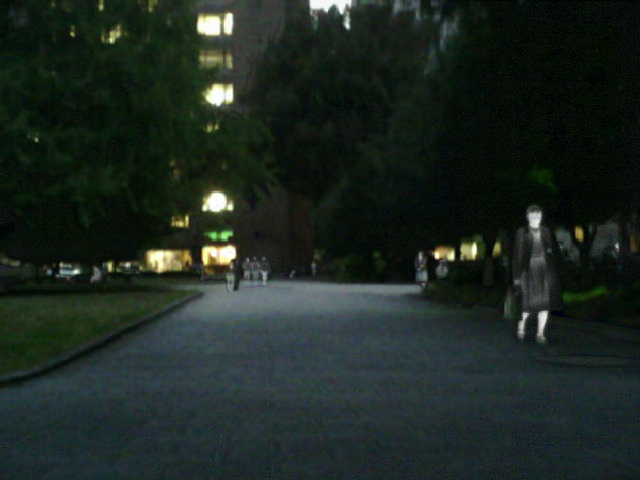

In [48]:
vi

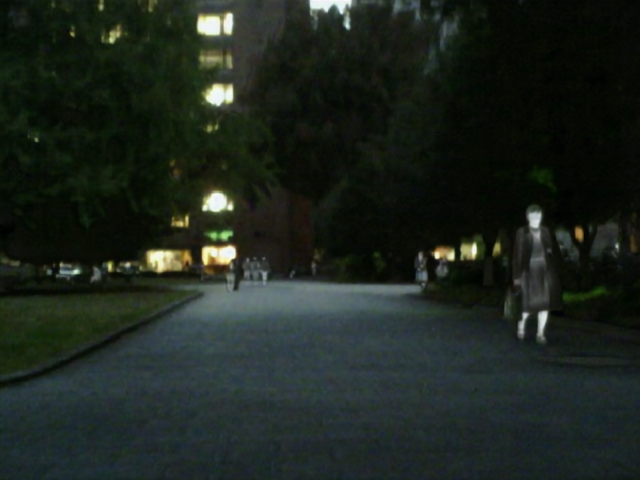

In [60]:
vi1